## https://www.kaggle.com/competitions/tgs-salt-identification-challenge/data


In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

from sklearn.model_selection import train_test_split

from skimage.transform import resize

# from tensorflow import keras
# import segmentation_models as sm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    

## Load data

In [3]:
train = pd.read_csv('./competition_data/competition_data/train.csv', index_col='id', usecols=[0])
depths = pd.read_csv('./competition_data/competition_data/depths.csv', index_col='id')
train = train.join(depths
                  )
test = depths[~depths.index.isin(train.index)]

In [4]:
train['images'] = [np.array(load_img('./competition_data/competition_data/train/images/{}.png'.format(idx),
                                    grayscale=True
                                    ))/255 for idx in tqdm_notebook(train.index)]

/tmp/ipykernel_6532/161441236.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  ))/255 for idx in tqdm_notebook(train.index)]


  0%|          | 0/4000 [00:00<?, ?it/s]

/home/alex/anaconda3/lib/python3.9/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
train['masks'] = [np.array(load_img('./competition_data/competition_data/train/masks/{}.png'.format(idx),
                                    grayscale=True
                                    ))/(255*257) for idx in tqdm_notebook(train.index)]

/tmp/ipykernel_6532/4080416984.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  ))/(255*257) for idx in tqdm_notebook(train.index)]


  0%|          | 0/4000 [00:00<?, ?it/s]

/home/alex/anaconda3/lib/python3.9/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


# Calculating the salt coverage and salt coverage classes¶
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [6]:
train['coverage'] = train.masks.map(np.sum)/(img_size_ori*img_size_ori)

In [7]:
def cov_to_classes(val):
    for i in range(0, 11):
        if val*10 <= i:
            return i
train['coverage_classes'] = train.coverage.map(cov_to_classes)

In [8]:
train.describe()

,z,coverage,coverage_classes
count,4000.000000,4000.000000,4000.000000
mean,506.706500,0.247966,2.805500
std,207.979243,0.318358,3.303846
min,51.000000,0.000000,0.000000
25%,351.000000,0.000000,0.000000
50%,514.000000,0.055485,1.000000
75%,669.000000,0.469268,5.000000
max,959.000000,0.999902,10.000000


/home/alex/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Coverage class')

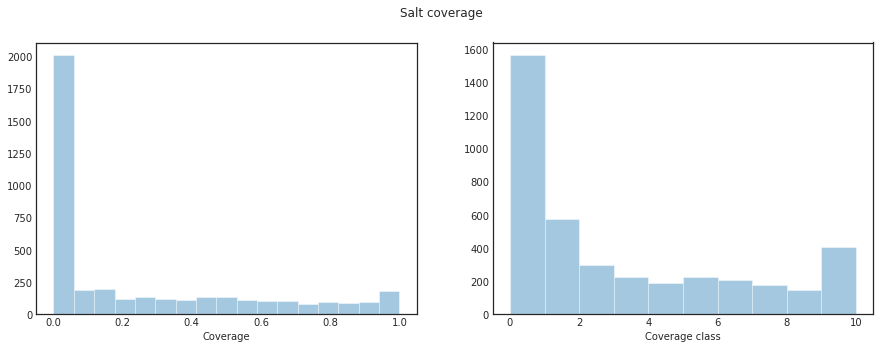

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train.coverage, kde=False, ax=ax[0])
sns.distplot(train.coverage_classes, bins=10, kde=False, ax=ax[1])
plt.suptitle("Salt coverage")
ax[0].set_xlabel("Coverage")
ax[1].set_xlabel("Coverage class")

Text(0, 0.5, 'coverage class')

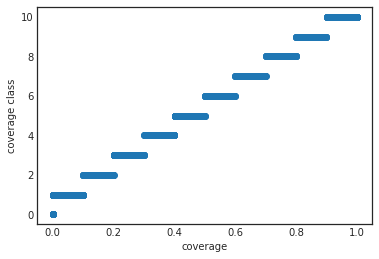

In [10]:
plt.scatter(train.coverage, train.coverage_classes)
plt.xlabel("coverage")
plt.ylabel('coverage class')

/home/alex/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Depth distribution')

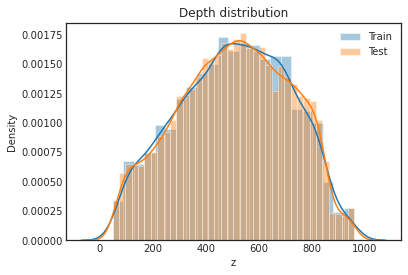

In [11]:
sns.distplot(train.z, label='Train')
sns.distplot(test.z, label='Test')
plt.legend()
plt.title('Depth distribution')

# Show some pictures

Text(0.5, 0.98, 'Green: salt. Top-right: coverage class,  bottom-left: depth')

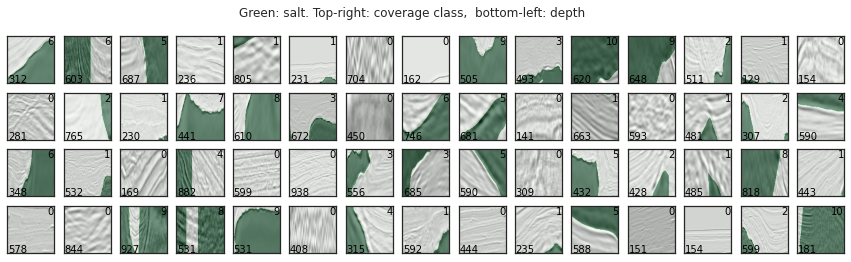

In [12]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train.index[:max_images]):
    img = train.loc[idx].images
    mask = train.loc[idx].masks
    ax = axs[(i//grid_width), i%grid_width]
    ax.imshow(img, cmap='Greys')
    ax.imshow(mask, alpha=0.5, cmap='Greens')
    ax.text(1, img_size_ori-1, train.loc[idx].z, color='black')
    ax.text(img_size_ori-1, 1, train.loc[idx].coverage_classes, color='black', ha='right', va='top')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-right: coverage class,  bottom-left: depth")

# Train/Test split

In [13]:
ids_train, ids_valid, X_train, X_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
train_test_split(
    train.index.values,
    np.array(train.images.map(upsample).to_list()).reshape(-1, img_size_target, img_size_target, 1),
    np.array(train.masks.map(upsample).to_list()).reshape(-1, img_size_target, img_size_target, 1),
    train.coverage.values,
    train.z.values,
    test_size=0.2, stratify=train.coverage_classes, random_state=42
)

Text(0.5, 1.0, 'Upscaled image')

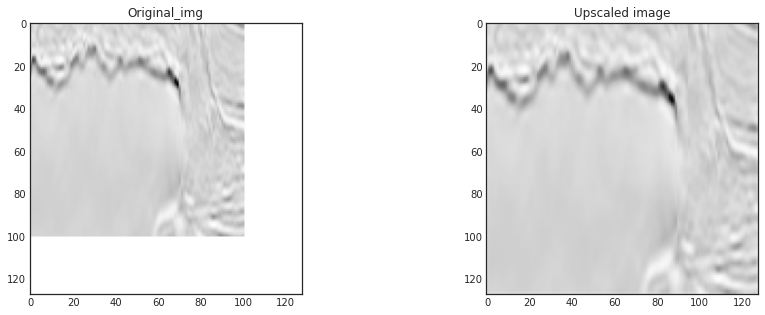

In [14]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train.images.loc[ids_train[10]]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap='Greys')
axs[0].set_title("Original_img")
axs[1].imshow(X_train[10].squeeze(), cmap='Greys')
axs[1].set_title("Upscaled image")

In [15]:
stop

NameError: name 'stop' is not defined

# Build model

In [ ]:
def build_model(input_layer, start_neurons):
    # 128->64
    conv1 = Conv2D(start_neurons*1, (3,3), padding='same', activation='relu')(input_layer)
    conv1 = Conv2D(start_neurons*1, (3,3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    
    # 64->32
    conv2 = Conv2D(start_neurons*2, (3,3), padding='same', activation='relu')(pool1)
    conv2 = Conv2D(start_neurons*2, (3,3), padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    
    # 32->16
    conv3 = Conv2D(start_neurons*4, (3,3), padding='same', activation='relu')(pool2)
    conv3 = Conv2D(start_neurons*4, (3,3), padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    
    # 16->8
    conv4 = Conv2D(start_neurons*8, (3,3), padding='same', activation='relu')(pool3)
    conv4 = Conv2D(start_neurons*8, (3,3), padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(0.5)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), padding='same', activation='relu')(pool4)
    convm = Conv2D(start_neurons*16, (3,3), padding='same', activation='relu')(convm)
    
    # 8->16
    deconv4 = Conv2DTranspose(start_neurons*8, (3, 3), strides=(2,2), padding='same')(convm)
    
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), padding='same', activation='relu')(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), padding='same', activation='relu')(uconv4)
    
    # 16->32
    deconv3 = Conv2DTranspose(start_neurons*4, (3, 3), strides=(2,2), padding='same')(uconv4)
    
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), padding='same', activation='relu')(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), padding='same', activation='relu')(uconv3)
    
    # 32->64
    deconv2 = Conv2DTranspose(start_neurons*2, (3, 3), strides=(2,2), padding='same')(uconv3)
    
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), padding='same', activation='relu')(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), padding='same', activation='relu')(uconv2)
    
    # 64->128
    deconv1 = Conv2DTranspose(start_neurons*1, (3, 3), strides=(2,2), padding='same')(uconv2)
    
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), padding='same', activation='relu')(uconv1)
    uconv1 = Conv2D(start_neurons*1, (3,3), padding='same', activation='relu')(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation='sigmoid')(uconv1)
    
    return output_layer

Input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(Input_layer, 16)

In [ ]:
model = Model(Input_layer, output_layer)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('./keras/model', save_best_only=True, verbose=1)
reduse_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 120
batch_size = 100

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping,model_checkpoint, reduse_lr]
                   )

In [17]:
model = load_model('./keras/model')

2023-02-07 11:46:23.328268: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-07 11:46:23.328477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 11:46:23.329420: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Predict the validation set
## Just checking results

In [18]:
predict_val = model.predict(X_valid).reshape(-1, img_size_target, img_size_target)
predict_val = np.array([downsample(x) for x in predict_val])
y_valid_ori = np.array([train.loc[idx].masks for idx in ids_valid])

2023-02-07 11:46:27.111903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-07 11:46:27.130806: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1190400000 Hz


Text(0.5, 0.98, 'Green: salt. Top-right: coverage class,  bottom-left: depth')

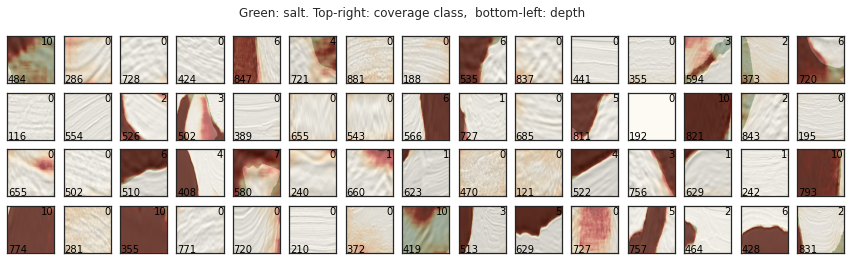

In [19]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train.loc[idx].images
    mask = train.loc[idx].masks
    pred = predict_val[i]
    ax = axs[(i//grid_width), i%grid_width]
    ax.imshow(img, cmap='Greys')
    ax.imshow(mask, alpha=0.5, cmap='Greens')
    ax.imshow(pred, alpha=0.5, cmap="OrRd")
    ax.text(1, img_size_ori-1, train.loc[idx].z, color='black')
    ax.text(img_size_ori-1, 1, train.loc[idx].coverage_classes, color='black', ha='right', va='top')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-right: coverage class,  bottom-left: depth")

# Scoring

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
thresholds = np.linspace(0, 1, 50)
ious = np.array(
    [iou_metric_batch(y_valid_ori, np.int32(predict_val > threshold)) for threshold in tqdm_notebook(thresholds)]
)

/tmp/ipykernel_6532/2246101011.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  [iou_metric_batch(y_valid_ori, np.int32(predict_val > threshold)) for threshold in tqdm_notebook(thresholds)]


  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
np.mean(ious)

0.6366875

In [30]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [34]:
X_test = np.array([upsample(np.array(
    load_img("./competition_data/competition_data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test.index)]
                 ) \
.reshape(-1, img_size_target, img_size_target, 1)

/tmp/ipykernel_6532/941241332.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  load_img("./competition_data/competition_data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test.index)]


  0%|          | 0/18000 [00:00<?, ?it/s]

/home/alex/anaconda3/lib/python3.9/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [35]:
preds_test = model.predict(X_test)

In [37]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test.index.values))}

/tmp/ipykernel_6532/2811959718.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test.index.values))}


  0%|          | 0/18000 [00:00<?, ?it/s]

In [38]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [ ]:
# src: ## https://www.kaggle.com/code/phoenigs/u-net-dropout-augmentation-stratification#Changelog